# Exploratory Data Analysis (EDA)

## Table of Contents
1. [Dataset Overview](#dataset-overview)
2. [Handling Missing Values](#handling-missing-values)
3. [Feature Distributions](#feature-distributions)
4. [Possible Biases](#possible-biases)
5. [Correlations](#correlations)


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
# import sys
# sys.path.append("../")
from Data.load_data import get_energy_data
import numpy as np

## Dataset Overview

### An important feature of the electricity load is multilevel seasonality.
The German electric load data, which include production from thermal energy and network feed-in from renewable energy, is publicly available at European Network of Transmission System Operators for electricity [ENTSO-E](https://energy-charts.info/charts/power/chart.htm?l=en&c=DE&source=entsoe) \
We analyze the data from January 1, 2017 to December 31, 2019. To avoid daylight savings, our time variable is at Coordinated Universal Time (UTC).


In [9]:
df = get_energy_data()

# Number of samples
num_samples = df.shape[0]

# Number of features
num_features = df.shape[1]

# Display these dataset characteristics
print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features}")

# Display the first few rows of the dataframe to show the structure
print("Example data:")
print(df.head())


Number of samples: 26280
Number of features: 2
Example data:
                               Load  Temperature
Date (UTC)                                      
2016-12-31 23:00:00+00:00  188528.8         -2.2
2017-01-01 00:00:00+00:00  183256.4         -2.4
2017-01-01 01:00:00+00:00  177785.3         -2.5
2017-01-01 02:00:00+00:00  172906.9         -2.7
2017-01-01 03:00:00+00:00  169715.8         -2.8


* Figure 1 shows seasonal and the weekly pattern of the consumption throughout the year.
* By seasons, the electricity load shows maximum values in winter and summer and minimum values in the transition periods, that is, spring and autumn.
* The electricity demand presents a weekly seasonality with minimum values on Sundays (the large falls observed in the curve each seven days).

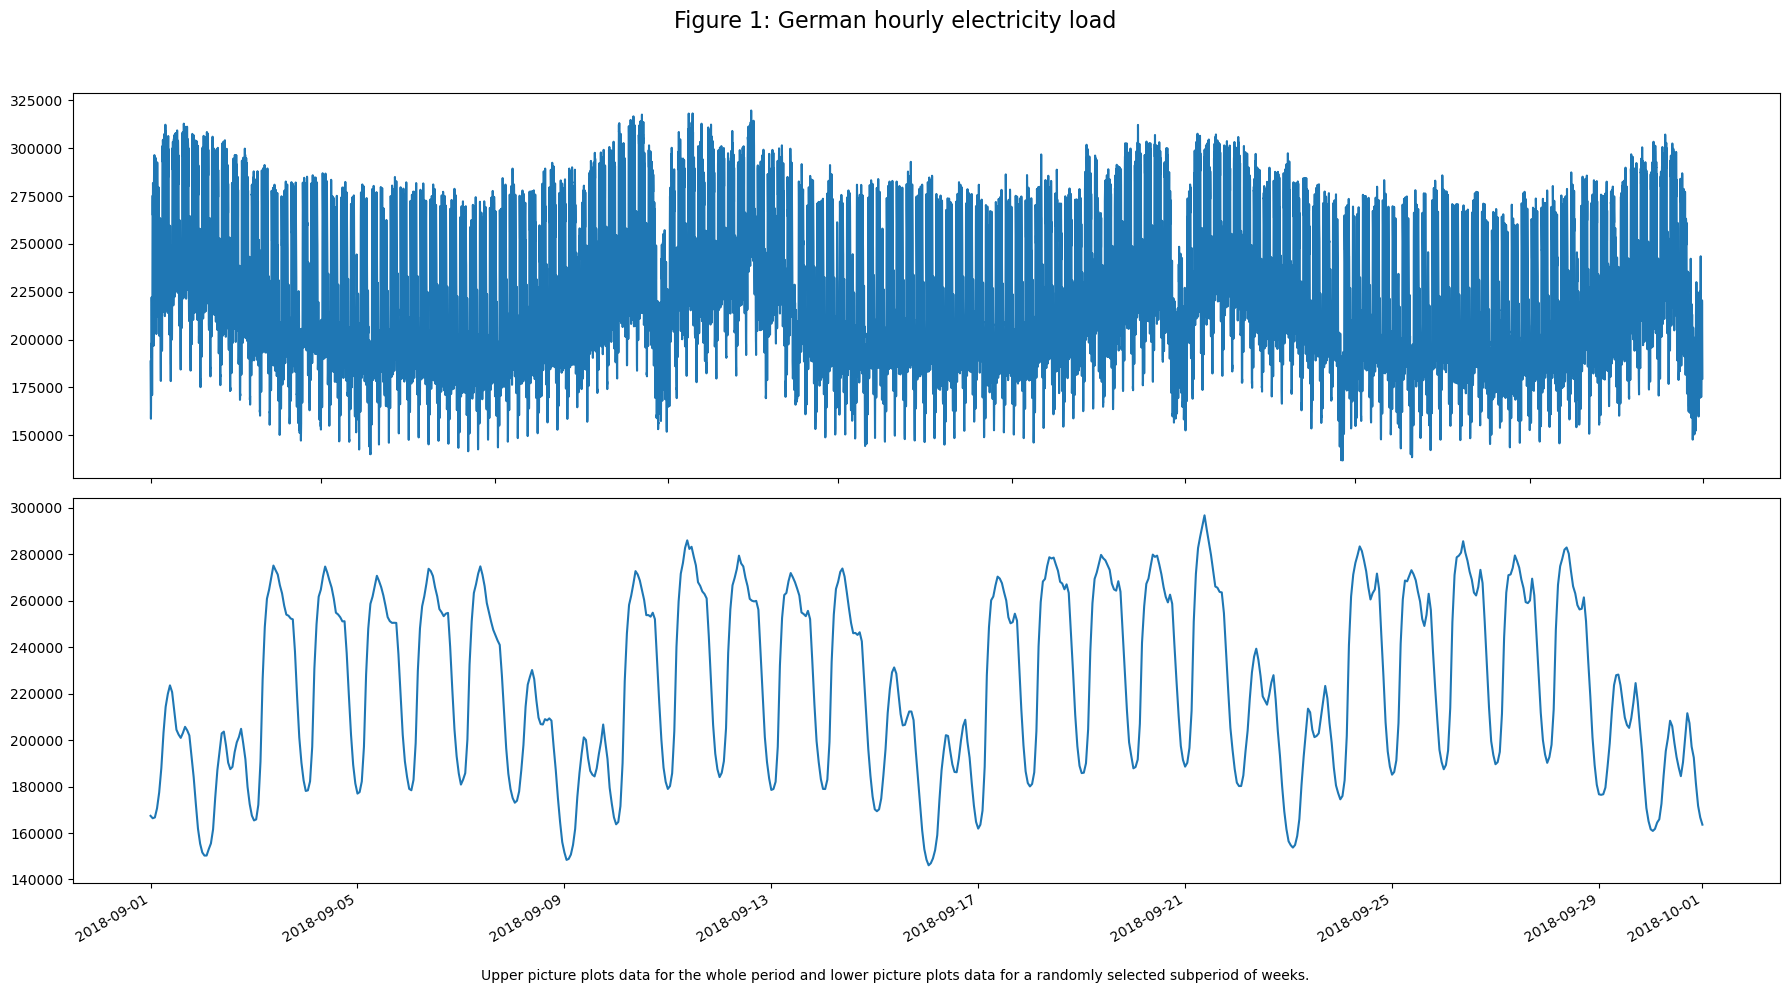

In [10]:
plt.figure(figsize=(18, 10))
plt.suptitle('Figure 1: German hourly electricity load', fontsize=16)

plt.subplot(2, 1, 1)
plt.plot(df['Load'])
plt.gcf().autofmt_xdate()

start_date = '2018-09-01'
end_date = '2018-10-01'
filtered_data = df[(df.index >= start_date) & (df.index <= end_date)]
plt.subplot(2, 1, 2)
plt.plot(filtered_data['Load'])
plt.gcf().autofmt_xdate()

footnote_text = 'Upper picture plots data for the whole period and lower picture plots data for a randomly selected subperiod of weeks.'
plt.figtext(0.5, 0.01, footnote_text, wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

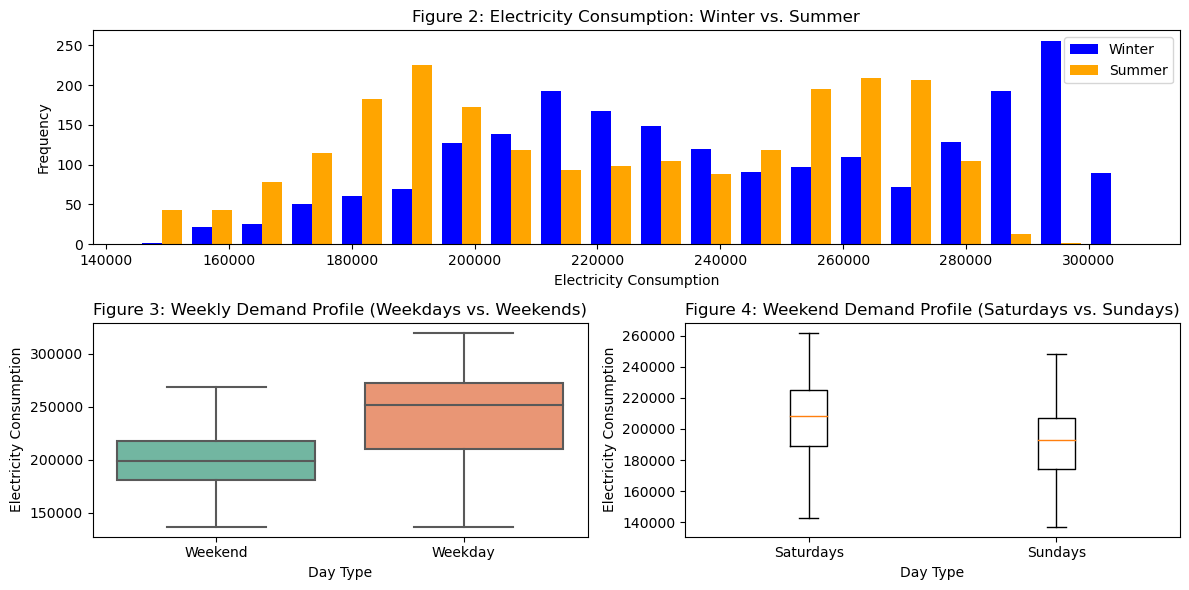

In [11]:
start_date = '2018-05-01'
end_date = '2019-05-01'
filtered_data = df[(df.index >= start_date) & (df.index <= end_date)]

# Seasonal Comparison (Winter vs. Summer)
winter_data = filtered_data[(filtered_data.index.month.isin([12, 1, 2]))]  # Filtering for December, January, February
summer_data = filtered_data[(filtered_data.index.month.isin([6, 7, 8]))]  # Filtering for June, July, August

# Filter data for Weekdays and Weekends
df['Weekday'] = df.index.weekday
df['Week'] = 'Weekday'
df.loc[df['Weekday'] >= 5, 'Week'] = 'Weekend'

# Filter data for Saturdays and Sundays
saturday = filtered_data[filtered_data.index.weekday == 5]
sunday = filtered_data[filtered_data.index.weekday == 6]

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(2, 2, (1, 2))
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 4)

# Subplot 1: Electricity Consumption - Winter vs. Summer
ax1.hist([winter_data['Load'], summer_data['Load']], bins=20, color=['blue', 'orange'], label=['Winter', 'Summer'])
ax1.set_title('Figure 2: Electricity Consumption: Winter vs. Summer')
ax1.set_xlabel('Electricity Consumption')
ax1.set_ylabel('Frequency')
ax1.legend()

# Subplot 2: Weekly Demand Profile - Weekdays vs. Weekends
sns.boxplot(x='Week', y='Load', data=df, ax=ax2, palette='Set2')
ax2.set_title('Figure 3: Weekly Demand Profile (Weekdays vs. Weekends)')
ax2.set_xlabel('Day Type')
ax2.set_ylabel('Electricity Consumption')

# Subplot 3: Weekend Demand Profile - Saturdays vs. Sundays
ax3.boxplot([saturday['Load'], sunday['Load']], labels=['Saturdays', 'Sundays'])
ax3.set_title('Figure 4: Weekend Demand Profile (Saturdays vs. Sundays)')
ax3.set_xlabel('Day Type')
ax3.set_ylabel('Electricity Consumption')

plt.tight_layout()
plt.show()

* The energy consumption is higher during winter than during summer.
* The weekly demand profile exhibits lower consumption during weekends, where Saturday is different from Sunday.
* Set dummy variables
  * month $(M_i)$, where $i$ = 1 (Jan.), 2 (Feb.), ..., 11 (Nov.), 0 (Dec.) \\
  * week $(W_j)$, where $j$ = 1 (Mon),..., 6 (Sat), 0 (Sun)

Hours of Daylight (HDL) is a useful variable in modelling UK load series. Therefore consider this variable also. First calculate the sun’s inclination angle

 $\lambda_t = 0.4102\sin (\frac{2\pi}{365}(d_t − 80.25)),$where $d_t \in \left [  1,365 \right ]$ and 1 represent January 1st, etc.

 Next calculate HDL from

 $7.722\arccos ( -\tan  \frac{2\pi \delta}{360} tan(\lambda_t)),$ where $\delta$ is the latitude. The latitude we used for Germany is 52&deg;

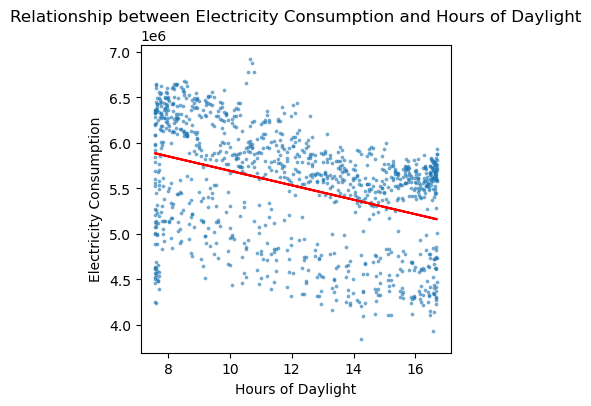

In [14]:
latitude = 52
days_of_year = range(1, 366)
lambda_t_value = [0.4102 * np.sin(2 * np.pi / 365 * (dt - 80.25)) for dt in days_of_year]
HDL_t = [7.722 * np.arccos(-np.tan(2 * np.pi * latitude / 360) * np.tan(lambda_t)) for lambda_t in lambda_t_value]
df_daily = df.resample('D').agg({'Load': 'sum', 'Temperature': 'mean', 'Weekday': 'mean'})
df_daily['Weekday'] = df_daily['Weekday'].astype(int)
df_daily = df_daily.iloc[1:]
HDL = np.tile(HDL_t, 3)
df_daily['HDL'] = HDL[:len(df_daily)]

plt.figure(figsize=(4, 4))
plt.scatter(df_daily['HDL'], df_daily['Load'], alpha=0.5, s=3)
x = df_daily['HDL']
y = df_daily['Load']
m, b = np.polyfit(x, y, 1)  # Fit a first-degree polynomial (linear)
plt.plot(x, m*x + b, color='red', label='Trend line')

plt.title('Relationship between Electricity Consumption and Hours of Daylight')
plt.xlabel('Hours of Daylight')
plt.ylabel('Electricity Consumption')
plt.show()

* The graph exhibits the inverse relation between consumption and hours of daylight.
* Set variable for the hours of daylight: $HDL_t$

Incorporating religious and public holidays effects is important in creating load forecast, because load is usually lower during holidays

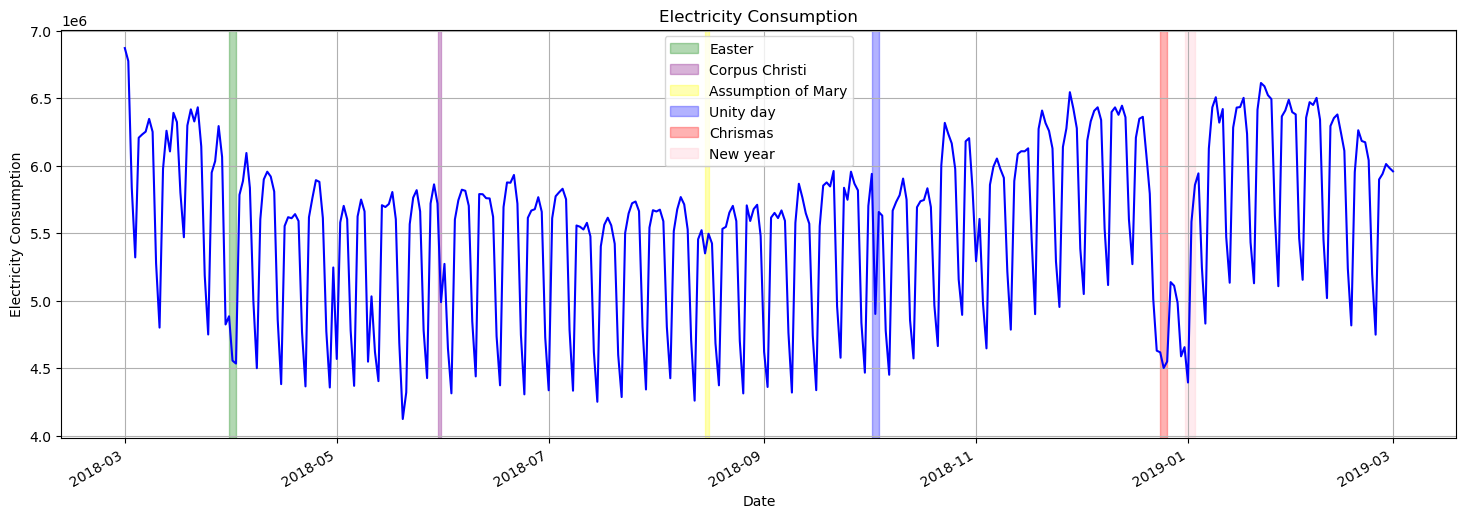

In [15]:
start_date = '2018-03-01'
end_date = '2019-03-01'
filtered_data = df_daily[(df_daily.index >= start_date) & (df_daily.index <= end_date)]

plt.figure(figsize=(18, 6))
plt.plot(filtered_data.index, filtered_data['Load'], color='blue')
plt.title('Electricity Consumption')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.axvspan('2018-03-31', '2018-04-02', color='green', alpha=0.3, label='Easter')
plt.axvspan('2018-05-30', '2018-05-31', color='purple', alpha=0.3, label='Corpus Christi')
plt.axvspan('2018-08-15', '2018-08-16', color='yellow', alpha=0.3, label='Assumption of Mary')
plt.axvspan('2018-10-02', '2018-10-04', color='blue', alpha=0.3, label='Unity day')
plt.axvspan('2018-12-24', '2018-12-26', color='red', alpha=0.3, label='Chrismas')
plt.axvspan('2018-12-31', '2019-01-03', color='pink', alpha=0.3, label='New year')
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()

plt.show()

* Public holidays and regional holidays have different impacts on the load.
* Set dummy variables for holidays
  * $PH_t$ for public holidays
  * $LH_t$ for local holidays
  * $H_{t-1}$ for the effect on adjacent days

There are several weather variables that are likely to affect electric consumption. Temperature is most commonly used by researchers.

Data of hourly average temperature is the arithmetic mean of all stations, obtained from [Deutscher Wetterdienst DWD, Climate Data Center (CDC)](https://energy-charts.info/charts/climate_hours/chart.htm?l=en&c=DE&interval=year&source=air_temperature)

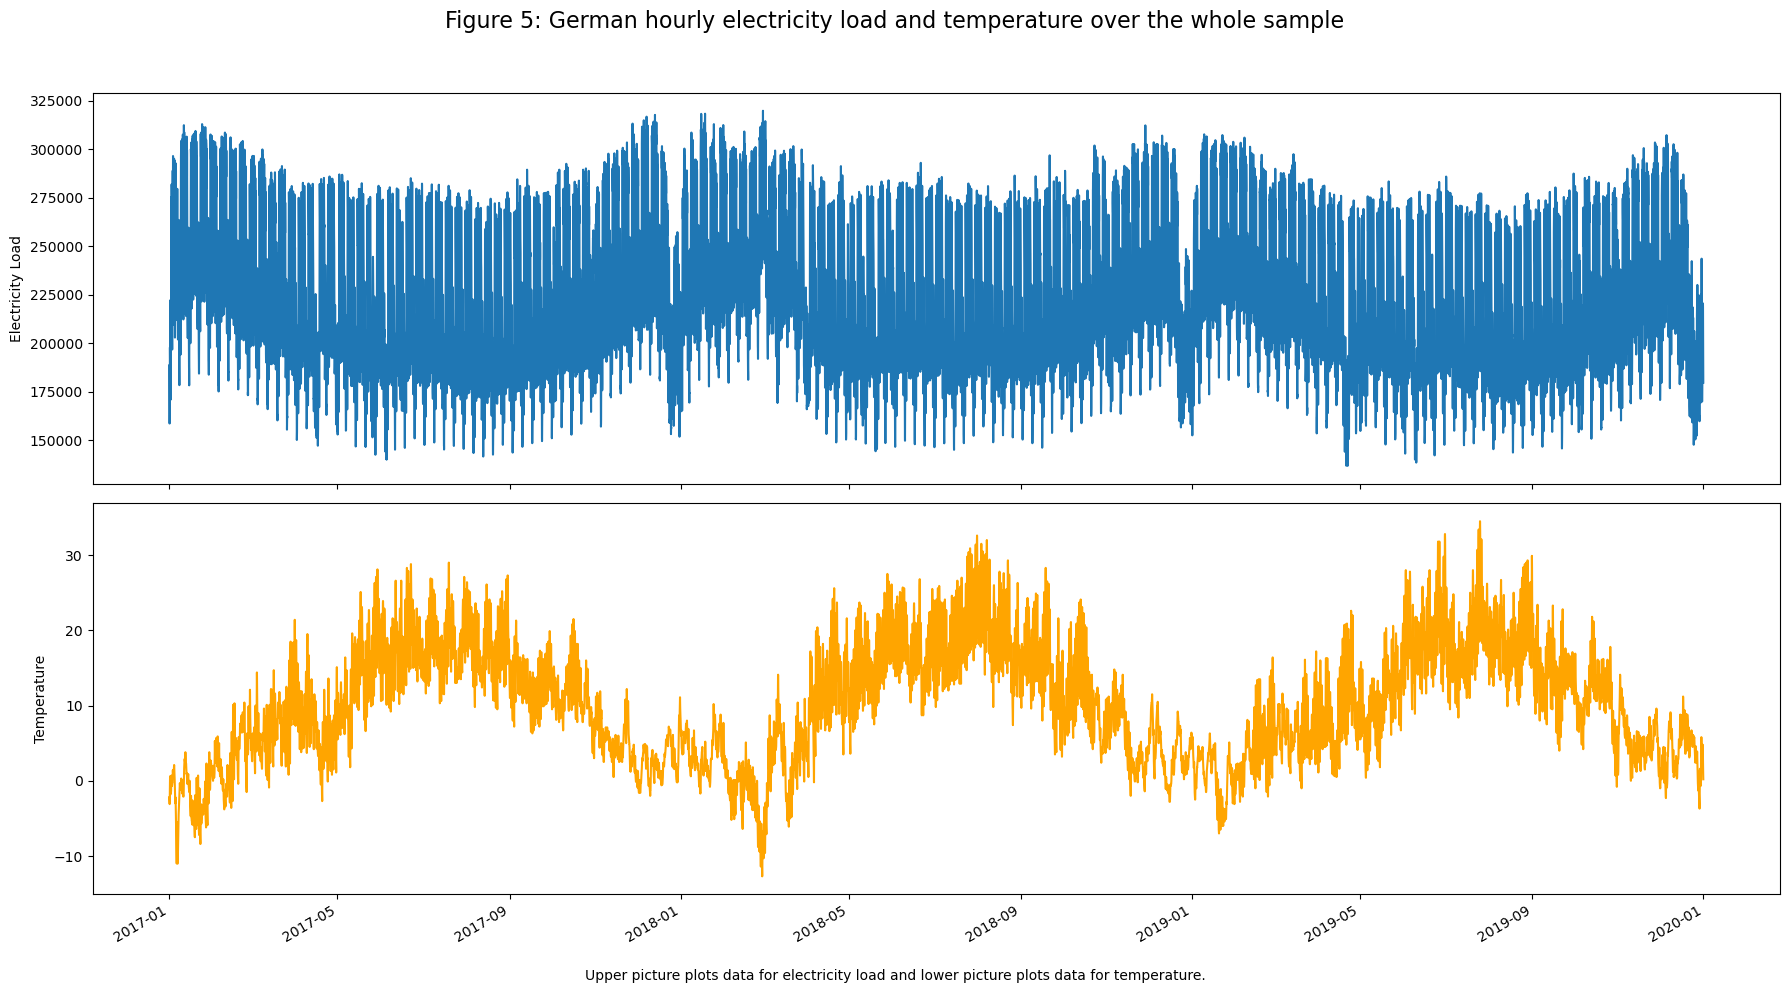

In [16]:
plt.figure(figsize=(18, 10))
plt.suptitle('Figure 5: German hourly electricity load and temperature over the whole sample', fontsize=16)

# Subplot 1: Electricity Load
plt.subplot(2, 1, 1)
plt.plot(df['Load'])
plt.ylabel('Electricity Load')

# Subplot 2: Temperature
plt.subplot(2, 1, 2)
plt.plot(df['Temperature'], color='orange')  # Change the color if needed
plt.ylabel('Temperature')
plt.gcf().autofmt_xdate()

footnote_text = 'Upper picture plots data for electricity load and lower picture plots data for temperature.'
plt.figtext(0.5, 0.01, footnote_text, wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

* As Figure 5 can be observed, temperature and electricity consumption have strong seasonal character, but move in opposite direction.
* Maximum electricity demand values are observed when maximum (summer) and minimum (winter) temperatures take place. The monthly peak electricity demand in winter is more important than that in summer.

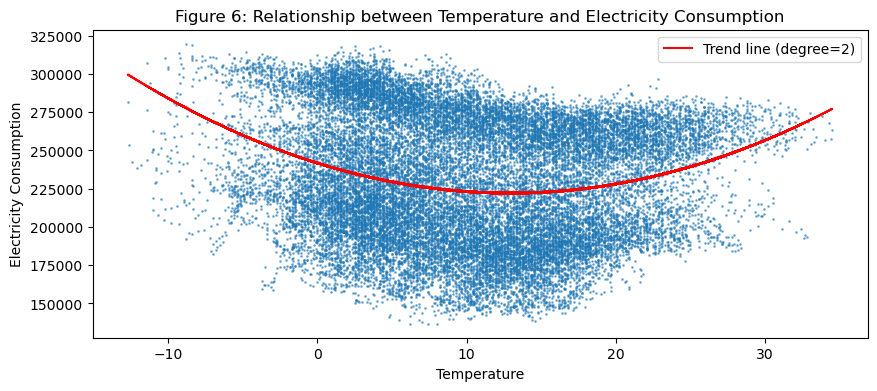

In [17]:
plt.figure(figsize=(10, 4))
plt.scatter(df['Temperature'], df['Load'], alpha=0.5, s=1)
plt.title('Figure 6: Relationship between Temperature and Electricity Consumption')
plt.xlabel('Temperature')
plt.ylabel('Electricity Consumption')

# Fitting a polynomial trend line (adjust the degree as needed)
degree = 2  # Example degree for the polynomial
p = np.poly1d(np.polyfit(df['Temperature'], df['Load'], degree))
plt.plot(df['Temperature'], p(df['Temperature']), color='red', label=f'Trend line (degree={degree})')
plt.legend()
plt.show()

However, the dependency of load on temperature is not linear. There are several options to model the temperature: One of them is quadratic function. The traditional and most used approach is to divide the model into two linear parts by transforming the average temperature to Heating Degree Days (HDD) and Cooling Degree Days (CDD).

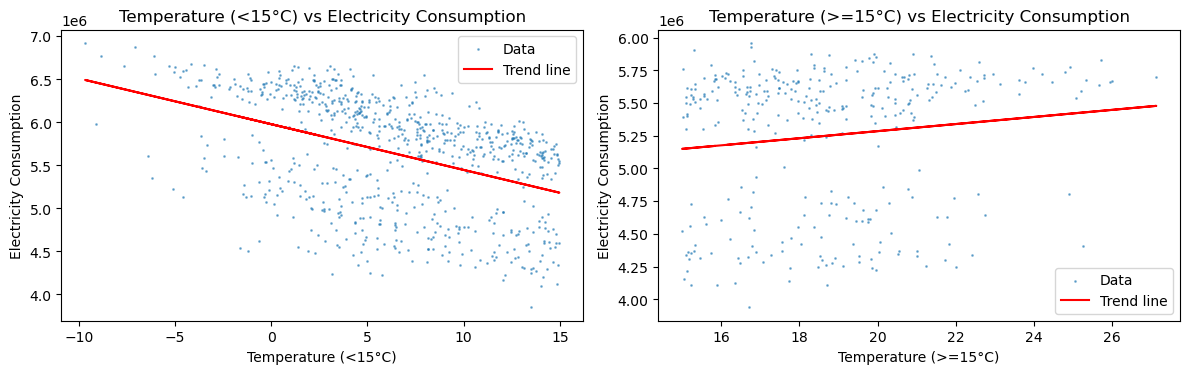

In [18]:
data_below_15 = df_daily[df_daily['Temperature'] < 15]
data_over_15 = df_daily[df_daily['Temperature'] >= 15]

# Set up subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].scatter(data_below_15['Temperature'], data_below_15['Load'], alpha=0.5, label='Data', s=1)
x = data_below_15['Temperature']
y = data_below_15['Load']
m, b = np.polyfit(x, y, 1)
axs[0].plot(x, m*x + b, color='red', label='Trend line')
axs[0].set_title('Temperature (<15°C) vs Electricity Consumption')
axs[0].set_xlabel('Temperature (<15°C)')
axs[0].set_ylabel('Electricity Consumption')
axs[0].legend()

axs[1].scatter(data_over_15['Temperature'], data_over_15['Load'], alpha=0.5, label='Data', s=1)
x = data_over_15['Temperature']
y = data_over_15['Load']
m, b = np.polyfit(x, y, 1)
axs[1].plot(x, m*x + b, color='red', label='Trend line')
axs[1].set_title('Temperature (>=15°C) vs Electricity Consumption')
axs[1].set_xlabel('Temperature (>=15°C)')
axs[1].set_ylabel('Electricity Consumption')
axs[1].legend()

plt.tight_layout()
plt.show()

* In Germany, the base temperature used for calculating HDD and CDD can vary but commonly falls around [15°C](https://energy-data.io/degree-days/#:~:text=According%20to%20the%20German%20standard%20VDI%203807%2C%20in%20Germany%2020,and%20internal%20gains%20into%20account.)
* From Figure 5 we see that the load does not increase during summer. Therefore, CDD, which is not an important variable in Germany.
* Set variable for Heating days: $HDD_t$

## Handling Missing Values and exclude duplicates

In [3]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values

# Check for duplicates


Load           0
Temperature    0
dtype: int64

No missing values found!

## Feature Distributions

[Plot the distribution of various features and target variables. Comment on the skewness, outliers, or any other observations.]


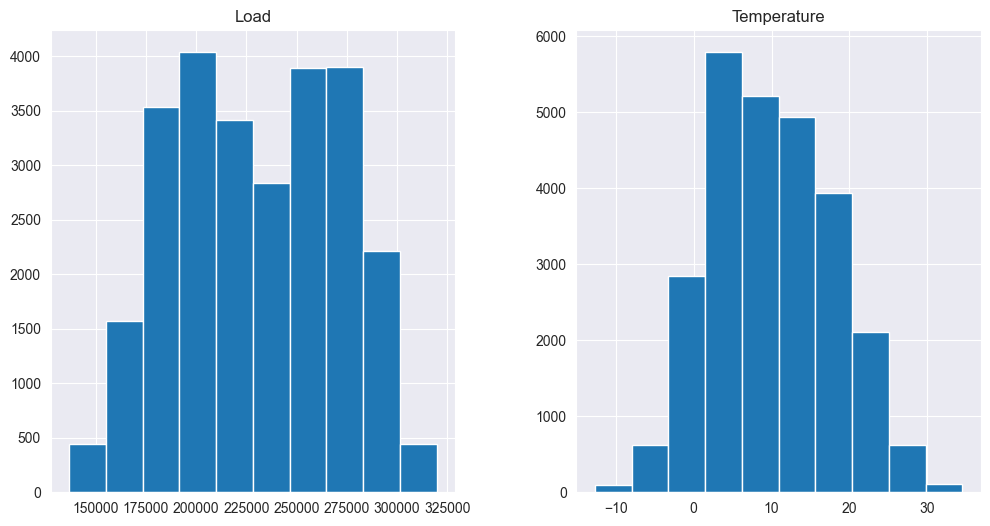

In [6]:
# Example: Plotting histograms of all numerical features
df.hist(figsize=(12, 6))
plt.show()

## Possible Biases

[Investigate the dataset for any biases that could affect the model’s performance and fairness (e.g., class imbalance, historical biases).]


In [ ]:
# Example: Checking for class imbalance in a classification problem
# sns.countplot(x='target_variable', data=df)

# Your code to investigate possible biases goes here


## Correlations

[Explore correlations between features and the target variable, as well as among features themselves.]


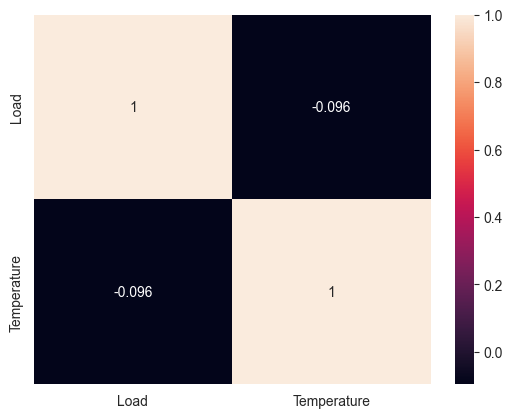

In [4]:
# Example: Plotting a heatmap to show feature correlations
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()
